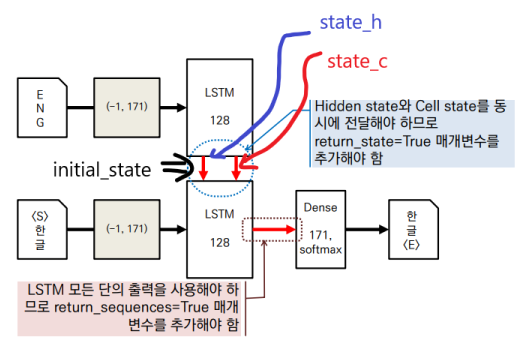

In [1]:
from tensorflow.keras import Sequential, Model, layers

enc_input = layers.Input(shape=(4, 171)) # 모든 영단어 4글자임
enc_out, state_h, state_c = layers.LSTM(128, return_sequences=True, return_state=True)(enc_input) # state_h(hidden state) <= return_sequences=True, state_c(cell state) <= return_state=True

dec_input = layers.Input(shape=(3, 171)) # 한글 단어 2자와 start 토큰 1개
dec_out = layers.LSTM(128, return_sequences=True)(dec_input, initial_state=(state_h, state_c)) # 디코더 아웃풋이 아님

output = layers.Dense(171, activation='softmax')(dec_out) # 디코더 아웃풋

model = Model(inputs=[enc_input, dec_input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 171)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 3, 171)]             0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 4, 128),             153600    ['input_1[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                              

In [2]:
# 데이터 불러오기
import numpy as np
import pandas as pd

# arr1 =['S', 'E', 'P', 'a', 'b', ...
arr1 = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']
print(arr1)
arr2 = pd.read_csv('korean.csv', header=None)
# print(arr2[0].values.tolist())
num_to_char = arr1 + arr2[0].values.tolist()
print(len(num_to_char))

['S', 'E', 'P', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
171


In [3]:
char_to_num = {char: i for i, char in enumerate(num_to_char)}

In [4]:
raw = pd.read_csv('translate.csv', header=None)
# raw.head()
eng_kor = raw.values.tolist()

In [5]:
temp_eng = 'love'
temp_eng_n = [char_to_num[c] for c in temp_eng]
print(temp_eng_n)

[14, 17, 24, 7]


In [6]:
temp_kor = '사랑'
temp_kor_n = [char_to_num[c] for c in temp_kor]
print(temp_kor_n)

[96, 66]


In [7]:
np.eye(5)[[2,3]]
#np.eye(5)[[1,2]] # 1행 2열 값
#np.eye(5)[[1,1]] # 1행 1열 값

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [8]:
np.eye(5)[[4,3,1]]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [9]:
np.eye(171)[[14,17,24,7]].shape

(4, 171)

In [10]:
def encode(eng_kor): # eng_kor => [['love', '사랑'], [..., ...], ....]
    enc_in = []
    dec_in = []
    rnn_out = []

    for seq in eng_kor:
        eng = [char_to_num[c] for c in seq[0]]
        enc_in.append(np.eye(171)[eng]) # eng리스트로 인덱싱

        kor = [char_to_num[c] for c in 'S'+seq[1]]
        dec_in.append(np.eye(171)[kor])

        target = [char_to_num[c] for c in seq[1]+'E']
        rnn_out.append(target) # loss 함수에서 sparse_를 붙일거니까...

    enc_in = np.array(enc_in)
    dec_in = np.array(dec_in)
    rnn_out = np.expand_dims(np.array(rnn_out), axis=2)
    
    return enc_in, dec_in, rnn_out

sample = [['word', '단어'], ['love','사랑']]
encode(sample)

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]),
 array([[[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]),
 array([[[ 61],
         [114],
         [  1]],
 
        [[ 96],
         [ 66],
         [  1]]]))

61 => '단' 인덱스\
114 => '어' 인덱스\
1 => 'E' 인덱스

96 => '사' 인덱스\
66 => '랑' 인덱스\
1 => 'E' 인덱스

In [11]:
encode(sample)[2]

array([[[ 61],
        [114],
        [  1]],

       [[ 96],
        [ 66],
        [  1]]])

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [20]:
X_enc, X_dec, y_rnn = encode(eng_kor)

In [21]:
model.fit([X_enc, X_dec], y_rnn, epochs=500)

Epoch 1/500
4/4 [==============================] - 3s 6ms/step - loss: 5.1357
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0965
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0460
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 4.9614
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 4.7960
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 4.4367
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 3.7797
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 3.5320
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 3.6012
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 3.4202
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 3.3822
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 3.3875
Epoch 13/500
4/4 [==============================] - 0s 5ms/st

In [24]:
input_data = [['tail', 'PP']]
in_, out_, _ = encode(input_data)
pred = model.predict([in_, out_])
#print(pred)
word = np.argmax(pred[0], axis=1)
print(word)
print(num_to_char[word[0]], num_to_char[word[1]])

1/1 [==============================] - 0s 20ms/step
[152  60   1]
크 다


In [25]:
#input_data = [['love', 'PP']]
input_data = [['loev', 'PP']] # 확률로 추론하기에 오타가 있어도 정상적으로 번역한다.
in_, out_, _ = encode(input_data)
pred = model.predict([in_, out_])
#print(pred)
word = np.argmax(pred[0], axis=1)
print(word)
print(num_to_char[word[0]], num_to_char[word[1]])

1/1 [==============================] - 0s 34ms/step
[96 66  1]
사 랑
